In [21]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import joblib


In [22]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [23]:
train.head(10)

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass
5,5,Arup Roy,HOWRAH MADHYA,AITC,0,3 Crore+,29 Lac+,WEST BENGAL,Graduate Professional
6,6,Baby Rani Maurya,AGRA RURAL (SC),BJP,0,2 Crore+,0,UTTAR PRADESH,Post Graduate
7,7,Neena Mittal,RAJPURA,AAP,1,9 Crore+,2 Crore+,PUNJAB,Graduate
8,8,Fareed Mahfooz Kidwai,RAM NAGAR,SP,1,5 Crore+,35 Lac+,UTTAR PRADESH,Post Graduate
9,9,Atul Moreshwar Save,AURANGBAD (EAST),BJP,6,22 Crore+,2 Crore+,MAHARASHTRA,Graduate


In [24]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
label_encoder = LabelEncoder()

In [25]:
education_mapping = {'Literate': 0, '5th Pass': 1, '8th Pass': 2, '10th Pass': 3, 
                     '12th Pass': 4, 'Graduate': 5, 'Post Graduate': 6, 
                     'Graduate Professional': 7, 'Doctorate': 8, 'Others': 9}

In [26]:
def getF1Score(model,X_val,y_val):
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred,average='weighted')
    print("F1 Score:", f1)  

In [27]:
def createSubmission(model,X_test,label_encoder):
    y_test=model.predict(X_test)
    df = pd.read_csv('test.csv')
    df = df[['ID']]
    # df['Education']=encoderEducation.classes_[y_test]
    # df['Education'] = [list(education_mapping.keys())[9] if i > 8 else list(education_mapping.keys())[i] for i in y_test]
    df['Education'] = label_encoder.inverse_transform(y_test)

    # Save the DataFrame to a new CSV file
    df.to_csv('output.csv', index=False)
    return y_test

In [28]:
def convert_financials(value):

    if isinstance(value, (float, int)):
        return value  
    value = value.replace('+', '').strip()  
    if 'Crore' in value:
        return float(value.replace('Crore', '')) * 10**7
    elif 'Lac' in value:
        return float(value.replace('Lac', '')) * 10**5
    elif 'Thou' in value:
        return float(value.replace('Thou', '')) * 10**3
    elif 'Hund' in value:
        return float(value.replace('Hund', '')) * 10**2
    return float(value)

In [29]:
def preprocess_features(data, encoder, fit_encoder = True):
    scaler=StandardScaler()
    data['Total Assets'] =  data['Total Assets'].apply(convert_financials)
    data['Liabilities'] =  data['Liabilities'].apply(convert_financials)

    data["Has Criminal Record"] = (data["Criminal Case"] > 0).astype(int) # binary variable
    data["Assets_liability"] =  (data['Total Assets']>data['Liabilities']).astype(int)# asset to liability ratio prop to education
    # data[["Assets_liability"]]=scaler.fit_transform(data[["Assets_liability"]])
    
    # data["Assets_liability"] = np.nan_to_num(data["Assets_liability"], nan=0)

    
    # financial distributions are skewed hence take log
    data['Log of Assets'] = np.log1p(data['Total Assets'])
    data['Log of Liabilities'] = np.log1p(data['Liabilities'])
    
    if encoder and fit_encoder:
        encoded_features = encoder.fit_transform(data[['Party', 'state']])
        encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Party', 'state']))
        data = pd.concat([data.drop(['Party', 'state'], axis=1), encoded_data], axis=1)
    elif encoder:
        encoded_features = encoder.transform(data[['Party', 'state']])
        encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Party', 'state']))
        data = pd.concat([data.drop(['Party', 'state'], axis=1), encoded_data], axis=1)

    return data
    
def preprocess_target(data, label_encoder=None, target_column=None, fit_encoder=False):
    if label_encoder and target_column:
        if fit_encoder:
            data[target_column] = label_encoder.fit_transform(data[target_column])
        else:
            pass
    return data

In [30]:
train_data = preprocess_features(train, encoder, fit_encoder=True)
train_data = preprocess_target(train_data, label_encoder, target_column='Education', fit_encoder=True)

test_data = preprocess_features(test, encoder, fit_encoder=False)
test_data = preprocess_target(test_data, label_encoder, target_column='Education', fit_encoder=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
train_data

,ID,Candidate,Constituency ∇,Criminal Case,Total Assets,Liabilities,Education,Has Criminal Record,Assets_liability,Log of Assets,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,0,M.K. Mohan,ANNA NAGAR,4,2.110000e+09,20000000.0,3,1,1,21.469954,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,Khatik Ramesh Prasad,KARERA (SC),0,1.000000e+07,0.0,1,0,1,16.118096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Dr. Mantar Gowda,MADIKERI,0,7.000000e+07,2200000.0,9,0,1,18.064006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Kundan Kumar,BEGUSARAI,0,9.000000e+07,2400000.0,9,0,1,18.315320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),2,2.000000e+07,6100000.0,3,1,1,16.811243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,1,6.100000e+06,1000000.0,6,1,1,15.623799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2055,2055,Pushkar Lal Dangi,MAVLI,0,2.000000e+07,800000.0,0,0,1,16.811243,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2056,2056,Dr. Manju Shiwach,MODI NAGAR,0,1.300000e+08,8500000.0,5,0,1,18.683045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2057,2057,Mansing Fattesingrao Naik,SHIRALA,1,2.500000e+08,9400000.0,1,1,1,19.336971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
train_data= train_data[train_data['Total Assets'] != 0]
X=train_data.drop(columns = ["ID", "Candidate", "Constituency ∇",'Total Assets','Liabilities', "Education","Criminal Case","Log of Liabilities","Log of Assets"], axis = 1)
y = train_data["Education"]

In [33]:
X

,Has Criminal Record,Assets_liability,Party_AAP,Party_AIADMK,Party_AITC,Party_BJD,Party_BJP,Party_CPI,Party_CPI(M),Party_DMK,...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2055,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2056,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2057,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assume 'data' is your DataFrame with 'Party' and 'Education level' columns

# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(X['Assets_liability'], y)


# Perform the chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2_stat)
print("p-value:", p_val)

Chi-squared statistic: 20.549372501456766
p-value: 0.01480874852109107


In [35]:
X_test=test_data.drop(columns = ["ID", "Candidate", "Constituency ∇",'Total Assets','Liabilities',"Criminal Case","Log of Liabilities","Log of Assets"], axis = 1)

In [36]:
rs=42
rf = RandomForestClassifier(random_state=rs)

# param_grid = {
#     'n_estimators': [100, 200, 300],  
#     'max_depth': [10, 20, 30, None],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4]     
# }
param_grid = {
    'n_estimators': [100,150, 200, 300,500],  
    # 'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 7,9],  
    # 'min_samples_leaf': [1, 2, 4]  
    'max_leaf_nodes':[200,500,700]   
}

f1 = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=f1, n_jobs=-1)
# X = train_data.drop(columns = ["ID", "Candidate", "Constituency ∇", "Education"], axis = 1)
# y = train_data['Education']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score: {:.3f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_val)

print("Validation F1 Score: {:.3f}".format(f1_score(y_val, y_pred, average='weighted')))


Best parameters: {'max_leaf_nodes': 200, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation F1 score: 0.217
Validation F1 Score: 0.217


In [37]:
best_rf=RandomForestClassifier(random_state=42,**grid_search.best_params_)
best_rf.fit(X,y)
createSubmission(best_rf,X_test,label_encoder)

array([1, 1, 9, ..., 5, 9, 9])

In [38]:
y1=pd.read_csv('Submission1.csv')

In [39]:
#joblib.dump(best_rf, 'model_rf_25.pkl')

# Plots 

In [81]:
X_train=pd.read_csv('train.csv')
X_test=pd.read_csv('test.csv')

X_train['Total Assets'] =  X_train['Total Assets'].apply(convert_financials)
X_test['Total Assets'] =  X_test['Total Assets'].apply(convert_financials)



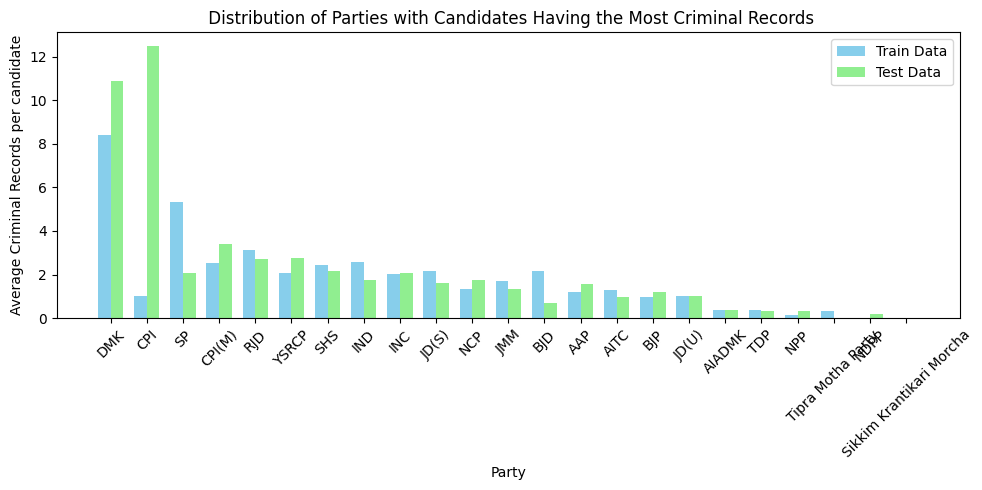

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique parties
parties = sorted(set(X_train['Party']).union(set(X_test['Party'])))

# Calculate the criminal records percentage for each party from train and test data
train_criminal_records_percentage = X_train.groupby('Party')['Criminal Case'].mean()
test_criminal_records_percentage = X_test.groupby('Party')['Criminal Case'].mean()

# Sum the values for each party from train and test data
total_criminal_records_percentage = (train_criminal_records_percentage + test_criminal_records_percentage).fillna(0)

# Sort parties based on total criminal records percentage in descending order
sorted_parties = total_criminal_records_percentage.sort_values(ascending=False)

# Set width of bars
bar_width = 0.35

# Set x axis range
x = np.arange(len(parties))

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, train_criminal_records_percentage.reindex(sorted_parties.index).values, width=bar_width, color='skyblue', label='Train Data')
plt.bar(x + bar_width/2, test_criminal_records_percentage.reindex(sorted_parties.index).values, width=bar_width, color='lightgreen', label='Test Data')
plt.title(' Distribution of Parties with Candidates Having the Most Criminal Records')
plt.xlabel('Party')
plt.ylabel('Average Criminal Records per candidate')
plt.xticks(x, sorted_parties.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('criminal_comparison.png')
plt.show()




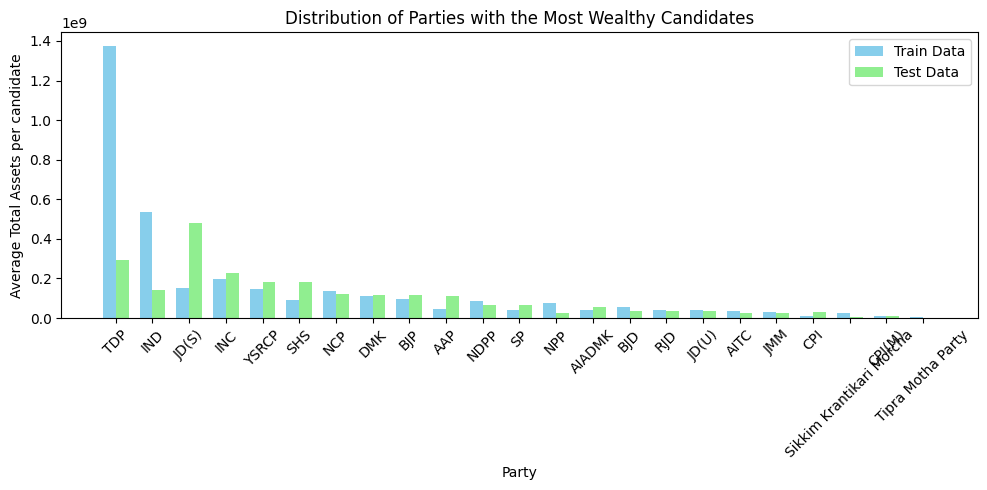

In [85]:

# Get unique parties
parties = sorted(set(X_train['Party']).union(set(X_test['Party'])))

# Calculate the total assets for each party from train and test data
train_total_assets = X_train.groupby('Party')['Total Assets'].mean()
test_total_assets = X_test.groupby('Party')['Total Assets'].mean()

# Sum the values for each party from train and test data
total_total_assets = (train_total_assets + test_total_assets).fillna(0)

# Sort parties based on total assets in descending order
sorted_parties_assets = total_total_assets.sort_values(ascending=False)

# Set width of bars
bar_width = 0.35

# Set x axis range
x = np.arange(len(parties))

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, train_total_assets.reindex(sorted_parties_assets.index).values, width=bar_width, color='skyblue', label='Train Data')
plt.bar(x + bar_width/2, test_total_assets.reindex(sorted_parties_assets.index).values, width=bar_width, color='lightgreen', label='Test Data')
plt.title('Distribution of Parties with the Most Wealthy Candidates')
plt.xlabel('Party')
plt.ylabel('Average Total Assets per candidate')
plt.xticks(x, sorted_parties_assets.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('total_assets_comparison.png')
plt.show()


